In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
import gymnasium
import cv2
from PIL import Image, ImageDraw
import os
from sklearn.metrics import confusion_matrix
#from tqdm import tqdm

In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_CLASSES = 10
IMG_SIZE = 128
NUM_IMAGES = 10000
MAX_SUBSET_SIZE = 200
CNN_EPOCHS = 2
REWARD_SMOOTHING_WINDOW = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class DataSet():
    def __init__(self):# 1. Параметры генератора
        self.CELL_COUNT_RANGE = (1, 10)  # Количество клеток на изображение (минимум, максимум)
        self.CELL_SIZE_RANGE = (5, 15)  # Диаметр клеток (минимум, максимум)
        self.CELL_COLOR_RANGE = ((100, 0, 0), (255, 100, 100))  # Цвет клеток (минимум, максимум по BGR)
        self.BACKGROUND_COLOR = (247, 131, 243)  # Розовый фон
        self.OVERLAP_PROBABILITY = 0.1  # Вероятность перекрытия клетки с другой

    def random_color(self, color_range):
        """Генерирует случайный цвет в заданном диапазоне."""
        return tuple(random.randint(color_range[0][i], color_range[1][i]) for i in range(3))

    def generate_blood_cell_image(self):
        """Генерирует одно изображение с клетками крови."""
        image = Image.new("RGB", (IMG_SIZE, IMG_SIZE), self.BACKGROUND_COLOR)
        draw = ImageDraw.Draw(image)
        cell_count = random.randint(self.CELL_COUNT_RANGE[0], self.CELL_COUNT_RANGE[1])
        cells = []  # Список координат и размеров клеток, чтобы отслеживать перекрытия

        for _ in range(cell_count):
            cell_size = random.randint(self.CELL_SIZE_RANGE[0], self.CELL_SIZE_RANGE[1])

            # Попробуем найти позицию для клетки, чтобы избежать перекрытия (если OVERLAP_PROBABILITY низкая)
            max_attempts = 100
            for attempt in range(max_attempts):
                x = random.randint(cell_size, IMG_SIZE - cell_size)
                y = random.randint(cell_size, IMG_SIZE - cell_size)

                # Проверяем, перекрывается ли новая клетка с существующими
                overlap = False
                if random.random() > self.OVERLAP_PROBABILITY: # Проверяем, нужно ли вообще проверять перекрытие
                    for existing_x, existing_y, existing_size in cells:
                        distance = np.sqrt((x - existing_x)**2 + (y - existing_y)**2)
                        if distance < (cell_size + existing_size) * 0.7:  # Уменьшил коэфф. для допущения небольшого перекрытия
                            overlap = True
                            break

                if not overlap:
                    break # Нашли подходящую позицию

            if overlap and attempt == max_attempts-1 :
                #Если не нашли хорошую позицию, то игнорируем данную клетку
                continue


            cell_color = self.random_color(self.CELL_COLOR_RANGE)
            draw.ellipse((x - cell_size, y - cell_size, x + cell_size, y + cell_size), fill=cell_color)
            cells.append((x, y, cell_size))

        return np.array(image), cell_count

    def generate_dataset(self,num_images, output_dir="blood_cell_dataset"):
        """Генерирует набор данных изображений и меток."""
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        images = []
        labels = []

        for i in range(num_images):
            image, cell_count = self.generate_blood_cell_image()
            images.append(image)
            labels.append(cell_count - 1) #label-1 to make 0 index

            # Сохранение изображений (опционально)
            image_path = os.path.join(output_dir, f"image_{i}.png")
            cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Convert to BGR for OpenCV

        return images, labels


In [ ]:
def get_dataloader(subset, shuffle=True):
    return DataLoader(subset, batch_size=BATCH_SIZE, shuffle=shuffle) #shuffle for training, False for evaluation


In [ ]:
class Flatten(nn.Module):
    def forward(self, batch):
        return batch.reshape(batch.size(0), -1)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.cv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.cv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = Flatten()
        self.fc1 = nn.Linear(64 * (IMG_SIZE//4) * (IMG_SIZE//4), 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = F.relu(self.cv1(x))
        x = self.pool(x)  # применяем пулинг после первой свертки
        #print(f"После первого пулинга: {x.shape}")
        x = F.relu(self.cv2(x))
        x = self.pool(x)  # применяем пулинг после второй свертки
        #print(f"После второго пулинга: {x.shape}")
        #print(f"Размер тензора после свертки: {x.shape}")
        x = self.flatten(x)
        #print(f"Размер тензора после flatten: {x.shape}")
        x = x.view(x.size(0), -1)  # или reshape
        #print(f"Размер тензора перед линейным слоем: {x.shape}")
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
class BloodCellDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        #self.images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]  # Преобразуем в градации серого
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        #image = np.expand_dims(image, axis=0)  # Добавляем канал (1, H, W)

        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to float and permute
        return image, torch.tensor(label, dtype=torch.long)


In [ ]:
class DataPreloading():
    def __init__(self, num_samples=NUM_IMAGES):
        self.dataset_generator = DataSet()
        images, labels = self.dataset_generator.generate_dataset(num_samples)

        self.dataset = BloodCellDataset(images, labels)
    def get_train_data(self):
        return self.dataset

torch.Size([10, 128, 128, 3])


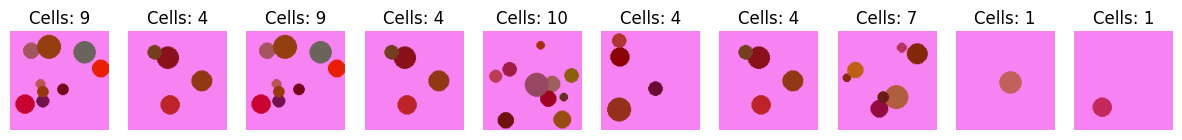

In [1481]:
NUM_IMAGES = 10
data_set = DataPreloading(num_samples=10)
data = data_set.get_train_data()
dataloader = DataLoader(data, batch_size=10, shuffle=True)
images, labels = next(iter(dataloader))
print(images.shape)
import matplotlib.pyplot as plt

def visualize_data(images, labels, num_samples=10):
    """Визуализирует несколько случайных изображений из набора данных."""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        index = random.randint(0, len(images) - 1)
        axes[i].imshow(images[index])
        axes[i].set_title(f"Cells: {labels[index]}")
        axes[i].axis('off')
    plt.show()

visualize_data(images, labels)

In [ ]:
class DataSelectionEnv(gymnasium.Env):
    def __init__(self):
        super(DataSelectionEnv, self).__init__()
        self.train_data = DataPreloading(num_samples=NUM_IMAGES).get_train_data()
        self.model = SimpleCNN().to(DEVICE) #Put the model on the available device
        self.criterion = nn.CrossEntropyLoss()
        self.indexes = self.class_select()
        self.optim = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)

        # Пространство действий: вероятности выбора изображений для каждого класса
        self.action_space = gymnasium.spaces.Box(low=0, high=1, shape=(NUM_CLASSES,), dtype=np.float32)
        self.observation_space = gymnasium.spaces.Box(low=0, high=1, shape=(NUM_CLASSES,), dtype=np.float32)

        #validation set
        self.validation_indices = random.sample(range(len(self.train_data)), int(0.2 * len(self.train_data)))
        self.validation_subset = Subset(self.train_data, self.validation_indices)
        self.validation_dataloader = get_dataloader(self.validation_subset, shuffle=False)

        self.reward_history = []  # To store rewards for smoothing
    def class_select(self):#возвращаем словарь из индексов принадлежащим классам
        ls = {i: [] for i in range(NUM_CLASSES)} #создали пустой словарь на 10 классов

        for x, (image, label) in enumerate(self.train_data): #unpack both
            label_value = label.item()
            ls[label_value].append(x) #индекс каждого изображения из train_data положили в нужный класс в зависимости от метки

        return ls

    def sample(self, action):#action - тензор распределения процентов изображений от каждого класса в выборке
        action = np.clip(action, 0, 1) #clip the action
        action = action / np.sum(action) #renormalize to ensure sum = 1
        index = []

        for i in range(NUM_CLASSES):
            num_img = int(action[i] * MAX_SUBSET_SIZE) #определили количество изображений для i-го класса в выборке из batch_size изображений
            indexes = np.random.choice(self.indexes[i], num_img, replace=True) #рандомно выбираем вычисленное количество изображений из изображений нужного класса, возвращаем их индексы
            index.extend(indexes)#добавляем найденные индексы в выборку

        return Subset(self.train_data, index)#состовляем subset

    def step(self, action):
        # в этой функции мы создаем выборку на основе action и проверяем, насколько улучшилось или ухудшилось предсказание сети
        action = np.clip(action + np.random.uniform(-0.05, 0.05, size=action.shape), 0, 1)
        train_subset = self.sample(action) #subset - выбранное случайное подмножество из 32 элементов на основе распределения action
        #test_subset = self.sample(action) #subset - выбранное случайное подмножество из 32 элементов на основе распределения action
        #Create test set - fixed
        train_dataloader = get_dataloader(train_subset) #создали dataloader, выдающий этот batch из 32 элементов
        #prev_acc, _ = self.evaluate(test_dataloader) #вычиляем текущую точность модели на тестовой выборке
        self.train_model(train_dataloader, epochs=CNN_EPOCHS) #тренируем модель на тренировчной выборке
        new_acc, err_per_cl = self.evaluate(self.validation_dataloader) #проверяем модель после тренировки на тестовой выборке

        self.reward_history.append(new_acc)
        if len(self.reward_history) > REWARD_SMOOTHING_WINDOW:
            self.reward_history.pop(0)
        smoothed_reward = np.mean(self.reward_history)

        reward = smoothed_reward

        for i in range(NUM_CLASSES):
            if err_per_cl[i]==1:
                reward-=5
            if err_per_cl[i]<1 and err_per_cl[i]>=0.9:
                reward+=1
            elif err_per_cl[i]<0.9 and err_per_cl[i]>=0.8:
                reward+=2
            elif err_per_cl[i]<0.8 and err_per_cl[i]>=0.7:
                reward+=3
            elif err_per_cl[i]<0.7 and err_per_cl[i]>=0.6:
                reward+=4
            elif err_per_cl[i]<0.6 and err_per_cl[i]>=0.5:
                reward+=5
            elif err_per_cl[i]<0.5:
                reward+=10

        #reward = new_acc
        return reward, err_per_cl

    def train_model(self, dataloader, epochs=5): #multiple epochs
        # на вход приходит dataloader выдающий batch изображений и ответов к ним
        self.model.train()
        for epoch in range(epochs):
            for images, labels in dataloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                self.optim.zero_grad() #обновили optimizer
                output = self.model(images) #получили тензор(batch_size, NUM_CLASSES) с распределением вероятностей для каждого изображения
                #print(output)
                loss = self.criterion(output, labels) #вычислили ошибку с помощью CrossEntropyLoss
                loss.backward()
                self.optim.step()

    def evaluate(self,dataloader):#тестирование модели
        self.model.eval()#перевели модель в оценочный режим
        correct = 0
        total = 0
        ls = [0]*NUM_CLASSES
        ers = [0]*NUM_CLASSES
        with torch.no_grad():
            #batchiter = iter(dataloader) #получили из dataloader batch на batch_size изображений
            for images, labels in dataloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                output = self.model(images) #получили тензор(batch_size,NUM_CLASSES) с распределениями вероятсностей для каждого изображения
                predicted = torch.argmax(output,dim=1) #получили тезор(batch_size) с предложенными значениями классов
                correct += (predicted==labels).sum().item() #нашли количество правильных ответов
                total += labels.size(0) #calculate all samples

                for i in range(len(labels)):
                    label = labels[i].item()
                    if predicted[i]==labels[i]:
                        ls[label]+=1
                    else:
                        ers[label]+=1
                        ls[label]+=1
            #print(ers,ls)
            error_per_class = [ers[i]/ls[i] if ls[i] > 0 else 0 for i in range(NUM_CLASSES)] #handle the zero division

        accuracy = (correct / total) if total > 0 else 0 # находим точность на данной выборке
        print("accuracy = ", accuracy)
        return accuracy, error_per_class


In [ ]:
class Actor(nn.Module):
    def __init__(self, input_size, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

class Critic(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
def actor_critic(env, actor, critic, episodes=10, max_steps=100, gamma=0.99, lr_actor=1e-3, lr_critic=1e-3):
    optimizer_actor = optim.AdamW(actor.parameters(), lr=lr_actor)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=lr_critic)
    actor.to(DEVICE)
    critic.to(DEVICE)

    # Create test set outside the loop for consistency
    test_dataset = DataPreloading().get_train_data()  # Get the full training data
    test_indices = random.sample(range(len(test_dataset)), int(0.2 * len(test_dataset)))  # 20% for test
    test_subset = Subset(test_dataset, test_indices)
    test_dataloader = get_dataloader(test_subset, shuffle=False)

    for episode in range(episodes):
        state = np.ones(NUM_CLASSES) / NUM_CLASSES  # Initialize state with equal distribution
        state_tensor = torch.FloatTensor(state).to(DEVICE)
        step = 0

        while step < max_steps:
            step += 1
            print(f"Episode: {episode+1}, Step: {step}, State: {state}")
            epsilon = 0.1  # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.dirichlet(np.ones(NUM_CLASSES))
            else:
                with torch.no_grad():
                    action_probabilities = actor(state_tensor)
                    action = action_probabilities.cpu().numpy()
            print(f"Episode: {episode+1}, Step: {step}, Action: {action}")
            reward, next_state = env.step(action)
            next_state_tensor = torch.FloatTensor(next_state).to(DEVICE)

            value = critic(state_tensor)
            next_value = critic(next_state_tensor)

            advantage = reward + (gamma * next_value) - value
            loss_critic = advantage.pow(2).mean()

            with torch.no_grad():
                td_target = reward + gamma * critic(next_state_tensor)
                delta = td_target - critic(state_tensor)

            action_probabilities = actor(state_tensor)
            log_prob = torch.log(action_probabilities)
            loss_actor = -log_prob * delta
            loss_actor = loss_actor.mean()

            entropy_bonus = -torch.sum(action_probabilities * torch.log(action_probabilities + 1e-6))
            loss_actor += 0.01 * entropy_bonus

            state = next_state
            state_tensor = next_state_tensor

            optimizer_actor.zero_grad()
            loss_actor.backward()
            optimizer_actor.step()

            optimizer_critic.zero_grad()
            loss_critic.backward()
            optimizer_critic.step()

            # Evaluate and print accuracy every 10 steps
            if step % 10 == 0:
                accuracy, _ = env.evaluate(test_dataloader)
                print(f"--------------------------------------")
                print(f"Episode: {episode+1}, Step: {step}, Test Accuracy: {accuracy:.4f}")
                print(f"--------------------------------------")

    return

In [ ]:
env = DataSelectionEnv()
actor = Actor(NUM_CLASSES, NUM_CLASSES)
critic = Critic(NUM_CLASSES)

actor_critic(env, actor, critic, episodes=10)
print("Training complete!")

0 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.07457279 0.09814458 0.11254901 0.10090239 0.09470567 0.12864526
 0.0886608  0.07965814 0.11115143 0.11100984]
[1, 0, 0, 1, 0, 1, 0, 1, 0, 0] [1, 0, 0, 1, 1, 1, 0, 1, 0, 0]


ZeroDivisionError: division by zero